In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import statsmodels.api as sm
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm

%matplotlib inline

In [2]:
data = pd.read_csv('electricity.csv')

In [3]:
data.head()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52


In [4]:
data.tail()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
5515,5515,4410.631913,14.70,5515,43,187
5516,5516,4292.029885,14.60,5516,44,188
5517,5517,4231.380523,14.65,5517,45,189
5518,5518,4587.536047,14.70,5518,46,190
5519,5519,4540.230041,14.75,5519,47,191


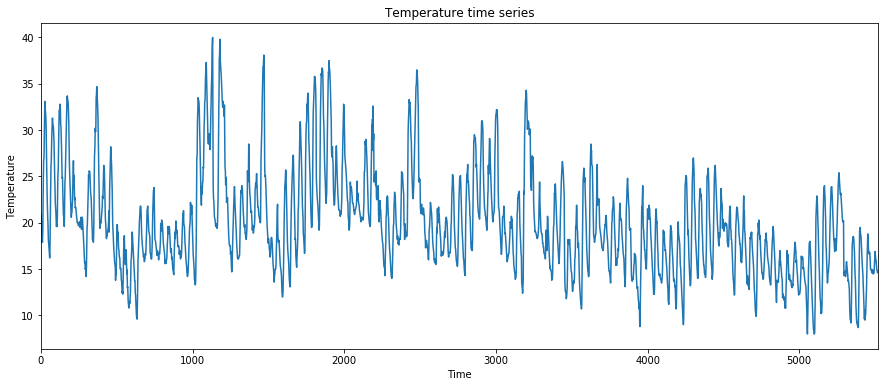

In [5]:
t = data['Temperature']
t.plot(figsize=(15, 6))

plt.title('Temperature time series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

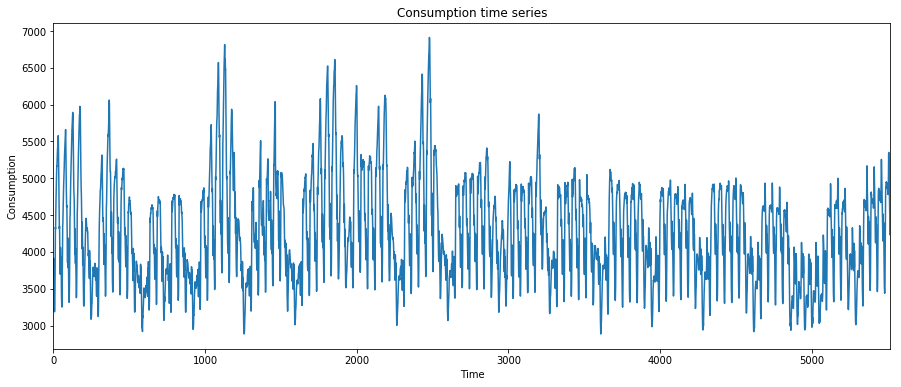

In [6]:
c = data['Consumption']
c.plot(figsize=(15, 6))

plt.title('Consumption time series')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

In [7]:
print(sps.spearmanr(t, c))
print(sps.kendalltau(t, c))

SpearmanrResult(correlation=0.57805418606949333, pvalue=0.0)
KendalltauResult(correlation=0.41337814259124334, pvalue=0.0)


In [8]:
train = data[:-48*7]
test = data[-48*7:]

In [9]:
train.head()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52


In [10]:
train.tail()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
5179,5179,4131.878165,16.65,5179,43,187
5180,5180,4023.872303,16.10,5180,44,188
5181,5181,3968.512667,15.65,5181,45,189
5182,5182,4330.536516,15.20,5182,46,190
5183,5183,4317.386273,14.75,5183,47,191


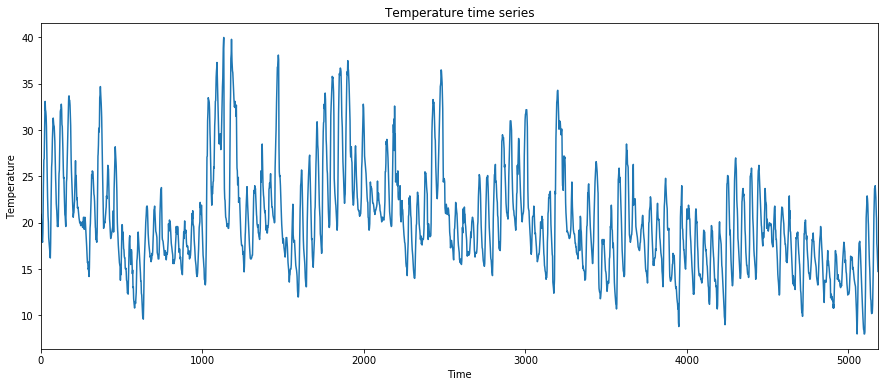

In [11]:
t = train['Temperature']
t.plot(figsize=(15, 6))

plt.title('Temperature time series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

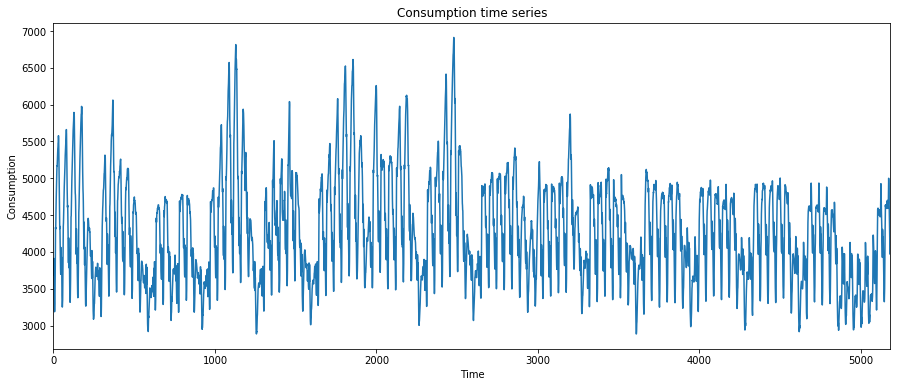

In [12]:
c = train['Consumption']
c.plot(figsize=(15, 6))

plt.title('Consumption time series')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

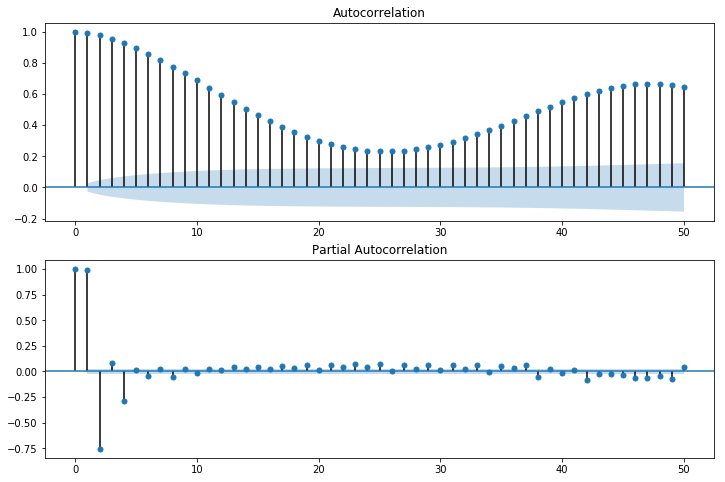

In [13]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(t, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(t, lags=50, ax=ax2)
plt.show()

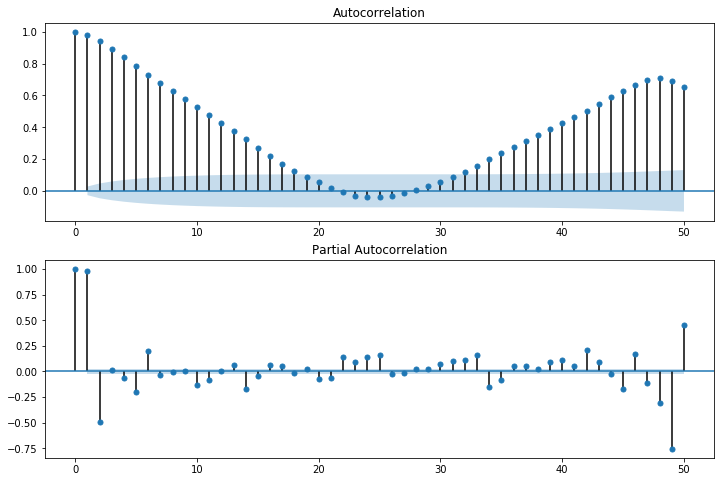

In [14]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(c, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(c, lags=50, ax=ax2)
plt.show()

In [15]:
T = np.array(t)
C = np.array(c)

In [16]:
def treatment(data):
    res = seasonal_decompose(data, freq=48)
    seasonal1 = res.seasonal

    d1data = data - seasonal1
    res = seasonal_decompose(d1data, freq=48*7)
    seasonal2 = res.seasonal

    d2data = d1data - seasonal2
    res = seasonal_decompose(d2data, freq=48*28)
    seasonal3 = res.seasonal

    trend = res.trend
    resid = res.resid
    
    fig = plt.figure(figsize=(12, 20))
    ax1 = fig.add_subplot(511)
    ax2 = fig.add_subplot(512)
    ax3 = fig.add_subplot(513)
    ax4 = fig.add_subplot(514)
    ax5 = fig.add_subplot(515)
    ax1.plot(trend)
    ax2.plot(seasonal1)
    ax3.plot(seasonal2)
    ax4.plot(seasonal3)
    ax5.plot(resid)
    plt.show()
    
    return resid[~np.isnan(resid)]

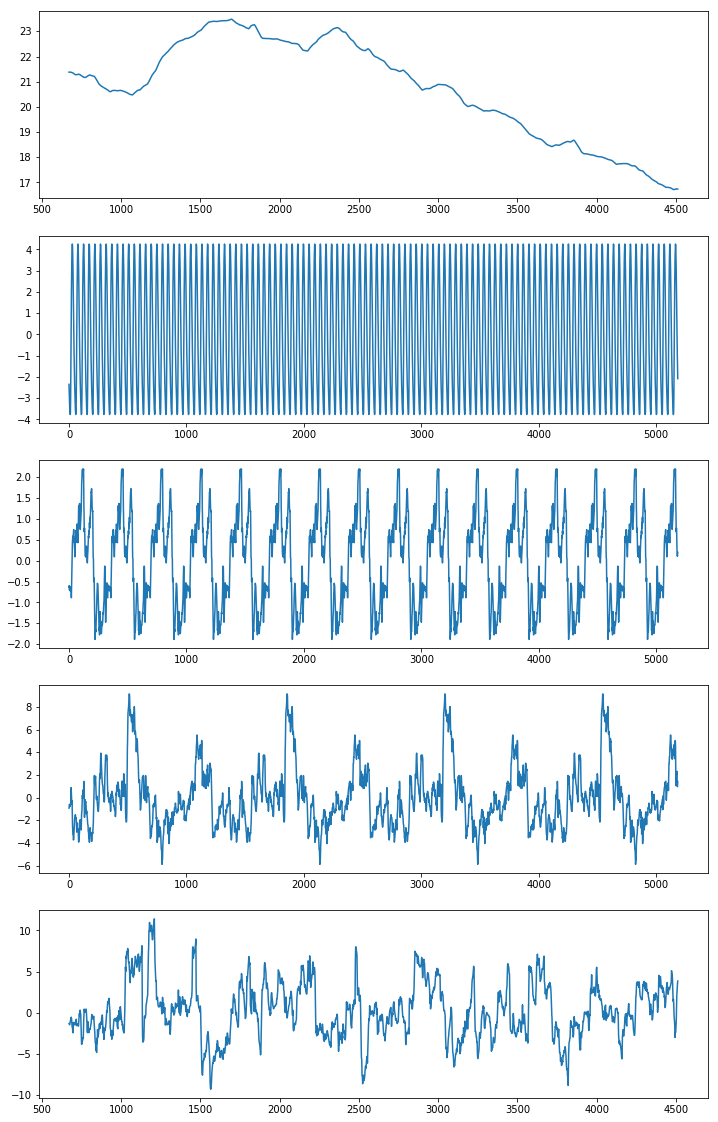

In [17]:
TEMP = treatment(T)

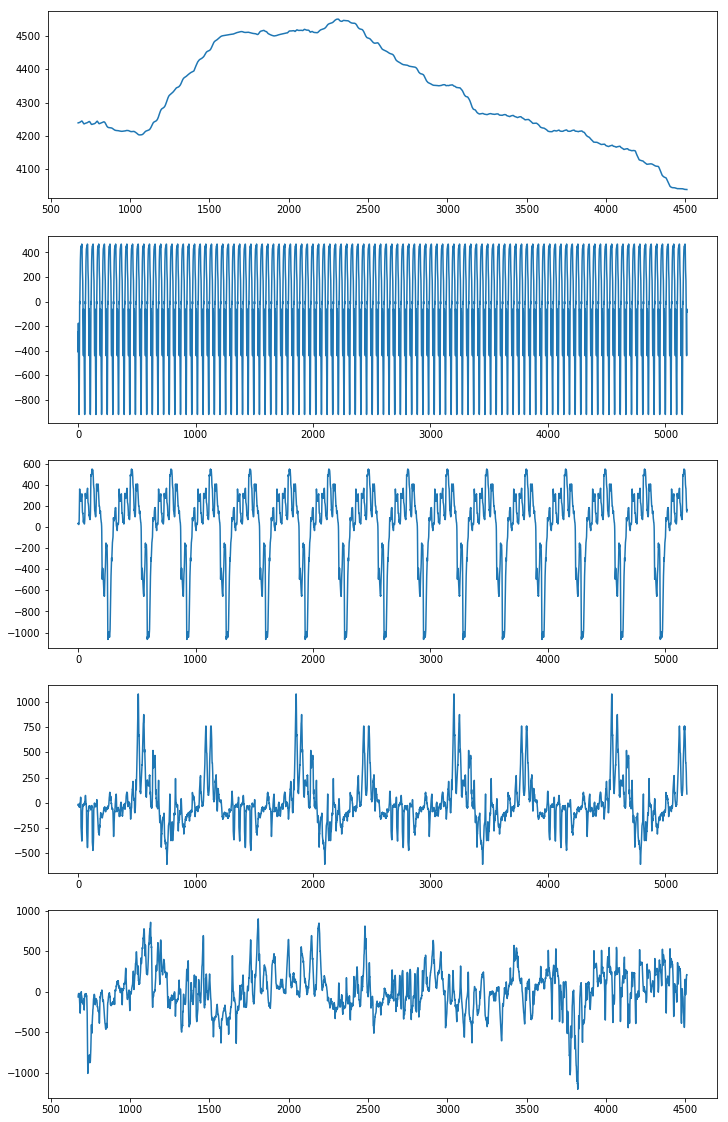

In [18]:
CONSUMPTION = treatment(C)

In [19]:
pvalues = np.array([kpss(T)[1], kpss(TEMP)[1], kpss(C)[1], kpss(CONSUMPTION)[1]])
res = multipletests(pvalues, method='bonferroni')
print("Гипотеза отклоняется:", res[0])
print("Скорректированные p-values:",res[1])

Гипотеза отклоняется: [ True False  True False]
Скорректированные p-values: [ 0.04  0.4   0.04  0.4 ]


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


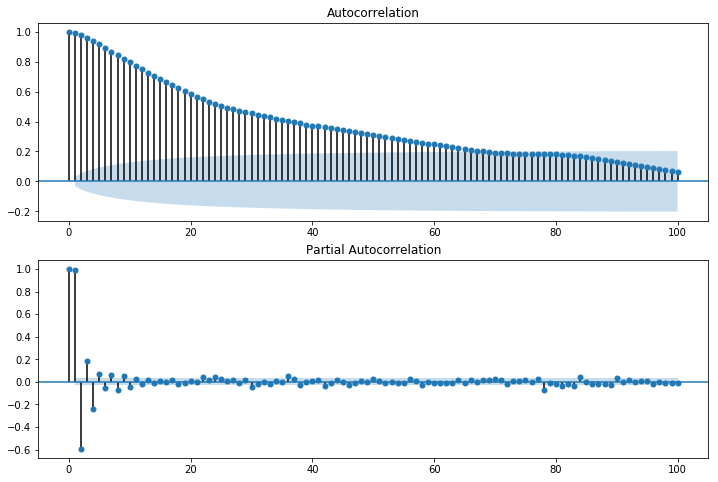

In [20]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(TEMP, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(TEMP, lags=100, ax=ax2)
plt.show()

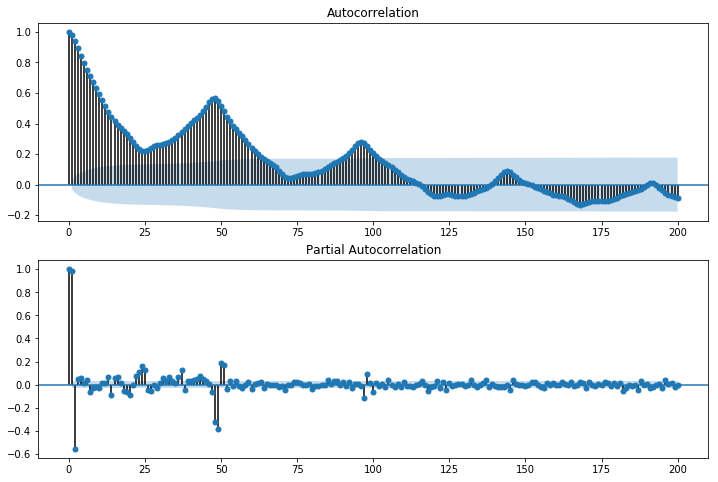

In [21]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(CONSUMPTION, lags=200, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(CONSUMPTION, lags=200, ax=ax2)
plt.show()

In [22]:
T = T.reshape(-1, 4)
T = T.mean(axis=-1)

In [23]:
startT84 = T[:84]
T84 = T[84:] - T[:-84]
startT841 = T84[:1]
T841 = T84[1:] - T84[:-1]

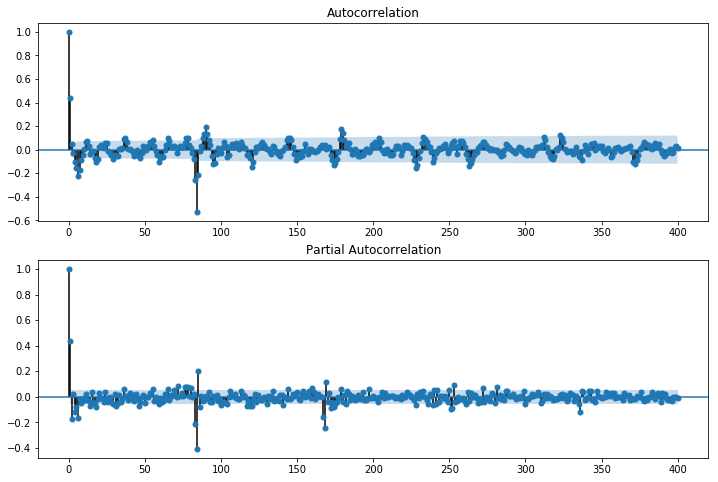

In [24]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(T841, lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(T841, lags=400, ax=ax2)
plt.show()

In [25]:
p = [0, 1, 2]
q = [0, 1]
d = [1]
P = [0, 1, 2]
D = [1]
Q = [0, 1, 2]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [26]:
warnings.filterwarnings('ignore')

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(T841, order=param, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}12 – AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 – AIC:4986.724017730905
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 – AIC:4938.666645688364
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 – AIC:5368.463064009021
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 – AIC:4988.00326841277
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 – AIC:4940.635142757618
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 – AIC:5173.1964816156005
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 – AIC:4942.026446832588
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 – AIC:4938.779293114788
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 – AIC:5618.5360597938225
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 – AIC:4906.717838457176
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 – AIC:4858.837726402231
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 – AIC:5260.87908987905
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 – AIC:4904.60730578577
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 – AIC:4860.741345988053
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 – AIC:5070.957002912816
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 – AIC:4864.2580150082085
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 – AIC:4857.940950214287
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 – AIC:5709.649335291689
ARIMA(1, 1

In [32]:
model = sm.tsa.statespace.SARIMAX(T841, order=(2, 1, 1), seasonal_order=(2, 1, 2, 12),
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5180      0.023     22.157      0.000       0.472       0.564
ar.L2         -0.1766      0.025     -7.086      0.000      -0.225      -0.128
ma.L1         -1.0000     17.568     -0.057      0.955     -35.432      33.432
ar.S.L12      -0.4247      0.376     -1.131      0.258      -1.161       0.311
ar.S.L24       0.0110      0.024      0.451      0.652      -0.037       0.059
ma.S.L12      -0.5451     46.313     -0.012      0.991     -91.316      90.226
ma.S.L24      -0.4550     21.015     -0.022      0.983     -41.643      40.733
sigma2         2.6228    129.569      0.020      0.984    -251.328     256.574


In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1211
Model:             SARIMAX(2, 1, 1)x(2, 1, 2, 12)   Log Likelihood               -2257.628
Date:                            Thu, 07 Dec 2017   AIC                           4531.256
Time:                                    20:52:54   BIC                           4572.049
Sample:                                         0   HQIC                          4546.615
                                           - 1211                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5180      0.023     22.157      0.000       0.472       0.564
ar.L2         -0.1766      0.025     -7.086      0.000      -0.225      -0.128
ma.L1         -1.0000     17.568     -0.057      0.955     -35.432      33.432
ar.S.L12      -0.4247      0.376     -1.131      0.258      -1.161       0.311
ar.S.L24       0.0110      0.024      0.451      0.652      -0.037       0.059
ma.S.L12      -0.5451     46.313     -0.012      0.991     -91.316      90.226
ma.S.L24      -0.4550     21.015     -0.022      0.983     -41.643      40.733
sigma2         2.6228    129.569      0.020      0.984    -251.328     256.574
===================================================================================
Ljung-Box (Q):                      113.96   Jarque-Bera (JB):               652.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

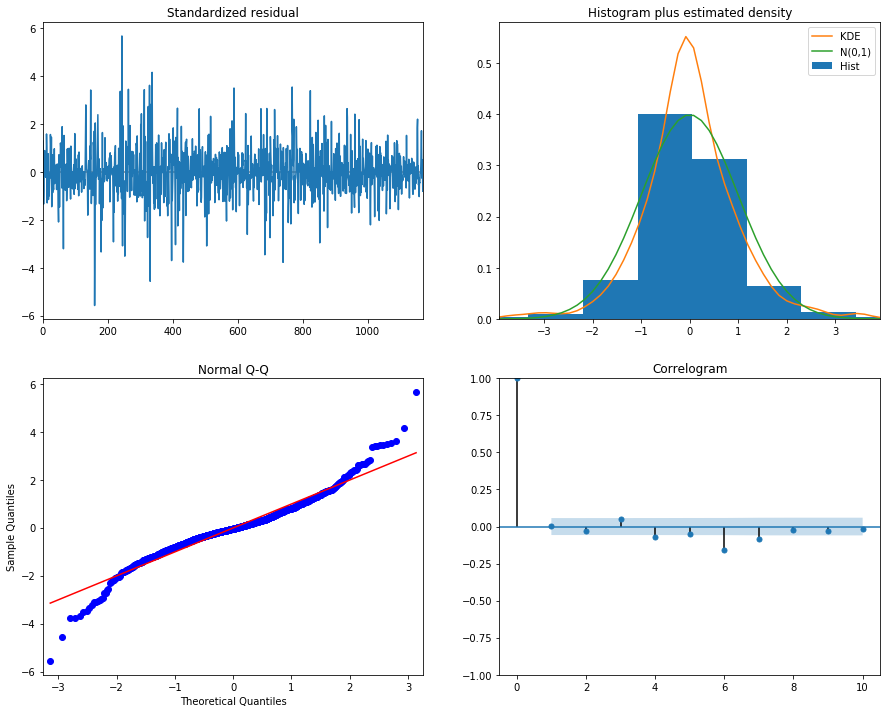

In [34]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [35]:
pred_dynamic = model.get_prediction(start=1211, end=1294, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [106]:
predict = pred_dynamic.predicted_mean

combine = T841
for t in range(84):
    combine = np.append(combine, combine[t - 84] + predict[t])
    
int1 = startT841
int1 = np.append(int1, combine[0] + startT841)
for t in range(1, 1295):
    int1 = np.append(int1, combine[t] + int1[t])
    
int2 = startT84
for t in range(1296):
    int2 = np.append(int2, int1[t] + int2[t])

prediction = np.zeros(5520)
for i in range(1380):
    prediction[4 * i] = int2[i]
    prediction[4 * i + 1] = int2[i]
    prediction[4 * i + 2] = int2[i]
    prediction[4 * i + 3] = int2[i]

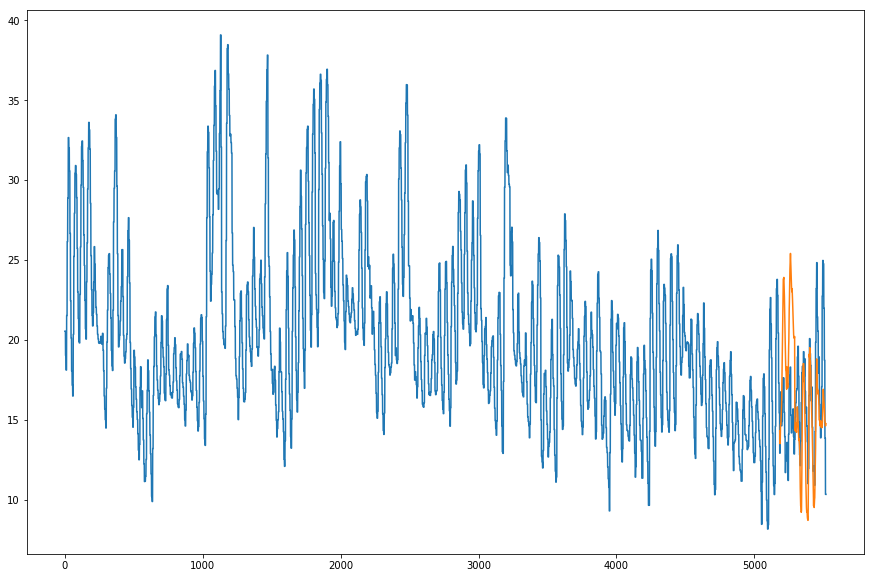

In [113]:
plt.figure(figsize=(15,10))
plt.plot(prediction)
plt.plot(test.Temperature)
plt.show()

In [117]:
check = prediction[-336:]
mse = ((prediction[-336:] - np.array(test.Temperature)) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 20.9
